In [2]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [3]:
Path.BASE_PATH = path
fname = (path/"images").ls()[0]

## Creating a Pet Breed Identifier

In [4]:
pets = DataBlock(
    blocks      = (ImageBlock, CategoryBlock),
    get_items   = get_image_files,
    splitter    = RandomSplitter(seed=42),
    get_y       = using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
    item_tfms   = Resize(460),
    batch_tfms  = aug_transforms(size=224, min_scale=0.75)
)

dls = pets.dataloaders(path/"images")

This code will create the required DataBlock which will organize our data for model training - it makes creating datasets much easier and handles a lot of stuff for us.

- This datablock sets the ImageBlock as the independent variable and the CategoryBlock as the dependent variable
- We then use the get_image_files function which when provided a path, will return a list of images in that path
- Then, we will randomly split the data into the default 80/20 split using a seed of 42
- Next, we tell it how to label each image (in this case we use a regex expression on the filename)
- Finally we use a data augmentation strategy called presizing

Presizing is designed to minimize data destruction and maintain good performance. It does so in two steps:
1. item_tfms -> Crop each image to full width or height (randomly in training, center square in validation)
2. batch_tfms -> Randomly crop and augment each image (applied to entire batch all at once on the GPU)

There's no guarantee that the blueprint will work as intended every time so before training the model we need to check the data to make sure it's all good.

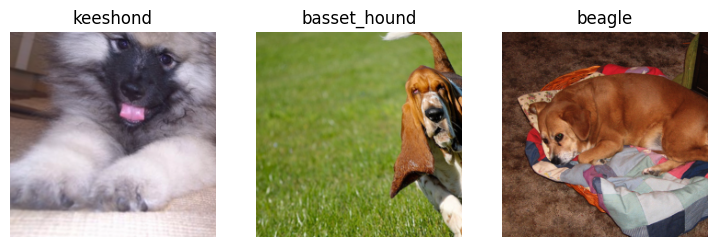

In [5]:
dls.show_batch(nrows=1, ncols=3)

It's also worth using the summary method for further debugging. It will attempt to create a batch from the source you tgive it, with a lot of details. If it fails, it will also tell you exactly at which point the error happens and the library will try to give you some help

In [6]:
pets.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/one6ix/.fastai/data/oxford-iiit-pet/images/leonberger_73.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=403x500
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /home/one6ix/.fastai/data/oxford-iiit-pet/images/leonberger_73.jpg
    applying partial gives
      leonberger
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(25)

Final sample: (PILImage mode=RGB size=403x500, TensorCategory(25))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting

Next step is to get a baseline by training a simple model

In [7]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.551835,0.304002,0.100135,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.512470,0.276361,0.090663,00:15
1,0.325293,0.248128,0.082544,00:15


We didn't specify a loss function, so fastai will choose the most appropriate one for us. Since we're using image data and a categorical outcome, fastai used cross-entropy loss

Cross-Entropy Loss is similar to our old loss function except it has two benefits:
1. It works even when our dependent variable has more than two categories
2. It results in faster and more reliable training

To understand why it works with more than two categories we need to look at our data and activations first

To get a batch of real data from our DataLoaders, we can use the one_batch method:

In [8]:
x, y = dls.one_batch()

This returns the dependent and independent variables, as a mini-batch. Let's see what is actually contained in the dependent variable

In [9]:
y

TensorCategory([ 8, 16,  5, 24, 23, 31, 29, 13,  7, 23, 33, 11, 10, 18, 22, 32,
                18, 25,  0, 29, 29, 26, 22,  3,  0, 13, 27, 33, 18, 35,  3,  9,
                 4, 18, 15, 20,  2, 14, 24, 10,  7, 16, 30, 30, 32, 30, 23, 21,
                29, 36, 19, 23,  5,  0, 21, 26,  1, 25, 20, 29,  6, 33, 10,  5],
               device='cuda:0')

- Our batch size is 64, thus we have 64 rows in this tensor. 
- Each row is a single number bewteen 0 and 36 representing 37 possible pet breeds
- We can view the predictions (the activations of the final layer of our neural network) using Leaner.get_preds
- This function either takes a dataset index (0 for train and 1 for valid) or an iterator of batches
- Therefore, we can pass it a simple list with our batch to get our predicitons. It returns predictions and targets by default.

In [10]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([2.9363e-06, 4.4952e-07, 9.1467e-01, 3.5204e-06, 3.9585e-06, 3.8347e-07,
        4.9636e-05, 1.6526e-04, 8.4828e-02, 2.6781e-07, 4.2320e-05, 3.3279e-07,
        6.8703e-07, 3.8416e-08, 1.4543e-06, 1.7487e-06, 2.4592e-07, 8.1104e-07,
        6.8119e-08, 6.0814e-07, 4.0459e-07, 1.5589e-05, 2.4591e-06, 8.8083e-05,
        7.1076e-06, 1.8219e-05, 4.1944e-08, 5.4924e-07, 7.7692e-05, 1.2252e-07,
        2.6021e-06, 9.7801e-06, 3.3972e-07, 1.5563e-07, 1.4438e-07, 3.3852e-07,
        5.6511e-07])

These predictions are 37 probabilities between 0 and 1, which add up to 1 in total

To transform the activations of our model into predictions like this, we used something called the softmax activation function.

A softmax function ensures that activations are between 0 and 1, and sum up to 1. It can be applied to a single column of activations from a neural network, and get back a column of numbers between 0 and 1, so its super useful for the final layer.

When we want to have more categories in our target, we need an activation per category. To showw this we'll create a neuralnet that predicts 3s and 7s and that returns two activations (one for each class). We'll use random numbers with a standard deviation of 2. We'll assume 6 images and 2 possible categories (where the first column represents 3s and the second is 7s)

In [11]:
torch.random.manual_seed(42)

acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

Note: you can't take the sigmoid of this directly, since the rows won't add up to 1 (we want probability of 3 plus probability of 7 to add up to 1)

Instead, we're going to take the difference bewteen the neural net activations, since this reflects how much more sure we are of the input being a 3 than a 7, and then take the sigmoid of that:

In [12]:
(acts[:,0] - acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

The second column, probability of input being a 7, will then just be these values subtracted from 1

The softmax function will do this exact thing but can operate on more than two columns. So to verify, we'll run softmax on `acts` and confirm that it returns the same values as sigmoid for the first column, and those values subtracted from 1 for the second column.

In [13]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

Just as we moved from sigmoid to softmax, we need to extend the loss function to work with any number of categories using log likelihood. We'll implementr this in PyTorch.

For the synthetic 3s and 7s example, let's say these are our labels:

In [14]:
targ = tensor([0,1,0,1,1,0])

and these aare the softmax activations:

In [15]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

Then for each item of targ, we can use that to select the appropriate column of sm_acts using tensor indexing:

In [16]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

This works because sm_acts[idx, targ] is essentially taking the targ and idx colummns as indices into the two-column matrix containing the 3 and 7 columns

PyTorch provides a function that does the same thing as sm_acts[range(n), targ] called nll_loss (negative loss likelihood)
- but it takes the negative, because when applying the log afterward, we will have negative numbers

In [17]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [18]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

Note: `nll_loss` does not take the log. It assumes you have already taken the log. PyTorch has a function called log_softmax that combines log and softmax in a fast and accurate way. `nll_loss` is designed to be used after log_softmax

Taking the mean of the negative log of our probabilities gives us the negative log likelihood loss (aka cross entropy loss).

When we first take the softmax, and then the log likelihood of that, we are performing cross-entropy loss. In PyTorch, its available as nn.CrossEntropyLoss (which does log_softmax and then nll_loss).

In [19]:
loss_func = nn.CrossEntropyLoss()

It is a class. Instantiating it gives you an object which behaves as a function:

In [20]:
loss_func(acts, targ)

tensor(1.8045)

All PyTorch loss functions are provided in two forms, the class and a plain functional form available in the F namespace:

In [21]:
F.cross_entropy(acts, targ)

tensor(1.8045)

Note: PyTorch loss functions will take the mean of the loss for all items by default. This can be disabled using the `reduction='none'` flag.

In [22]:
F.cross_entropy(acts, targ, reduction='none')

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

## Model Interpretation

Loss functions are for computers to differentiate and optimize - not for humans to understand. Instead we use metrics to interpret how well the model is doing. One of the key metrics of a model is the confusion matrix

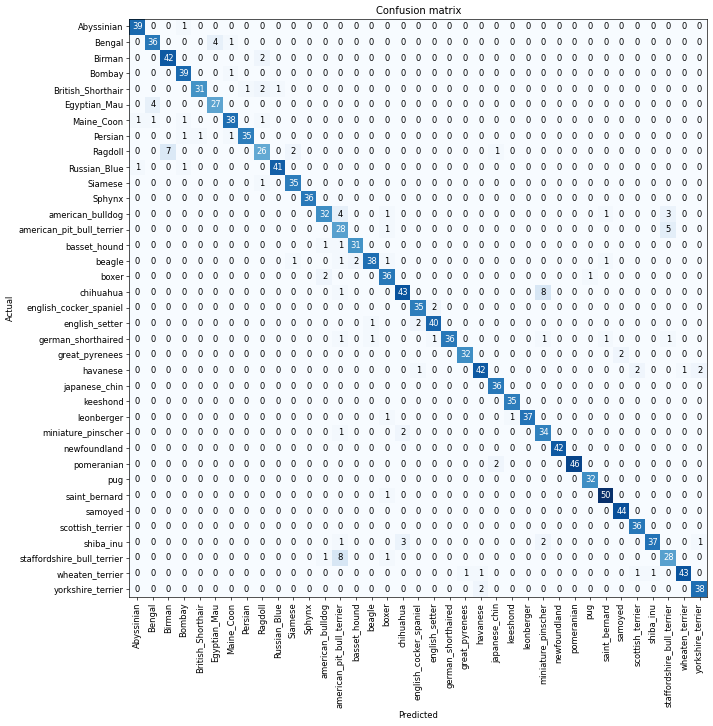

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Because there are 37 breeds, the matrix is huge and pretty hard to read. So we can use the `.most_confused(min_val=5)` to give us the cells with the most incorrect predictions (at least 5)

In [24]:
interp.most_confused(min_val=5)

[('chihuahua', 'miniature_pinscher', np.int64(8)),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', np.int64(8)),
 ('Ragdoll', 'Birman', np.int64(7)),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', np.int64(5))]

Turns out these errors are pretty common, even among breed experts, so we're along the right track.

## Improving the model

One of the ways we can improve our model is by selecting the right learning rate. We can easily do this using the learning rate finder provided by fastai.

This tool will start from an extremely small learning rate to a high one and plot the loss values on the path. It works by iterating through the range of learning rates on a mini-batch and saving the loss generated using each learning rate. 

Here's how it can be used:

/home/one6ix/Documents/GitHub/fastbook/.venv/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_lo

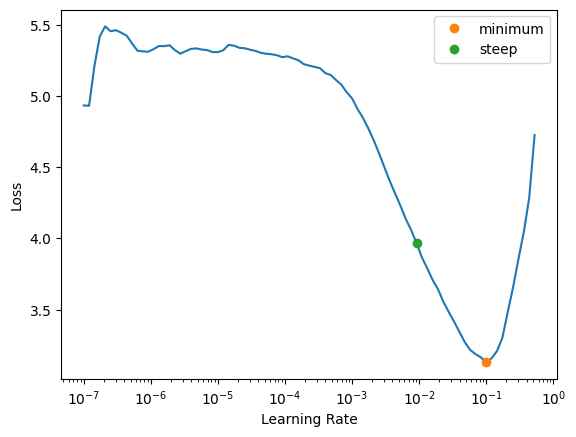

In [25]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [26]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 9.12e-03


Another way in which we can improve the model is using unfreezing and transfer learning. Essentially, we're going to replace the last linear layer from a pretrained model with a new one containing random weights. Then we'll train the model in such a way that we allow it to remember all of the generally useful ideas to solve our particular task, and only adjust them as required for the specifics of our task.

When we create a model from a pretrained network fastai automatically freezes all of the pretrained layers for us. Using the fine_tune method does two things:
1. Trains the randomly added layers for one epoch, with all other layers frozen
2. Unfreezes all of the layers, and trains them all for the number of epochs requested

So let's try doing this manually:
- First we'll train the randomly added layers for three epochs, using fit_one_cycle
- fit_one_cycle is the suggested way to train models without using fine_tine because it starts training at a low learning rate, gradually increasing during the first section of training, then gradually decreasing it during the last section of training

In [27]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.163194,0.387921,0.126522,00:12
1,0.570946,0.243886,0.075778,00:12
2,0.325515,0.224508,0.080514,00:12


Then we'll unfreeze the model

In [28]:
learn.unfreeze()

Finally, we'll have to run lr_find again, because our old learning rate is no longer appropriate

/home/one6ix/Documents/GitHub/fastbook/.venv/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_lo

SuggestedLRs(valley=5.248074739938602e-05)

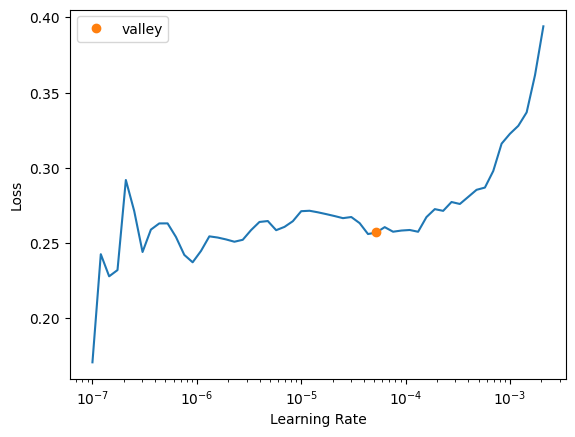

In [29]:
learn.lr_find()

The graph looks a lot different - a flat area before a sharp increase. We don't have the sharp descent indicating the model is training because it has been trained already. Thus, we want to take a point well before the sharp increase. The point with the maximum gradient isn't what we look for here and should be ignored.

In [30]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.252079,0.216692,0.075778,00:16
1,0.243184,0.211596,0.070365,00:15
2,0.234432,0.209549,0.067659,00:15
3,0.210932,0.195458,0.064953,00:15
4,0.191998,0.195585,0.067659,00:15
5,0.185697,0.198344,0.068336,00:15


We could also use discriminative learning rate to further improve our model since the deepest layers might not need as high of a learning rate as the last ones. 
- We care a lot about the quality of the pre trained weights
- The learning rate for the pretrained weights will be signficiantly lower than the learning rate for the random layers

fastai let's you pass a Python slice object anywhere that a learning rate is expected. The final value passed will be the learning rate in the earliest layer and the second value will be the learning rate in the final layer of the neural network. The layers in between will have learning rates that are multiplicatively equidistant throughout that range. 

Let's use this approach to replicate the previous trainijng, but this time we'll only set the lowesst layer of our net to a learning rate of 1e-6; the other layers will scale up to 1e-4

In [5]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.147883,0.377625,0.119756,00:12
1,0.539615,0.263961,0.084574,00:11
2,0.336575,0.226491,0.071719,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.269097,0.219967,0.066306,00:15
1,0.251521,0.211717,0.068336,00:15
2,0.239180,0.201459,0.059540,00:15
3,0.210922,0.194734,0.061570,00:15
4,0.195603,0.193401,0.062923,00:16
5,0.188778,0.187455,0.059540,00:16
6,0.153574,0.197606,0.061570,00:16
7,0.148611,0.190690,0.062923,00:16
8,0.141639,0.186927,0.060893,00:16
9,0.129195,0.184396,0.059540,00:16


fastai can show us a graph of the training and validation loss:

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

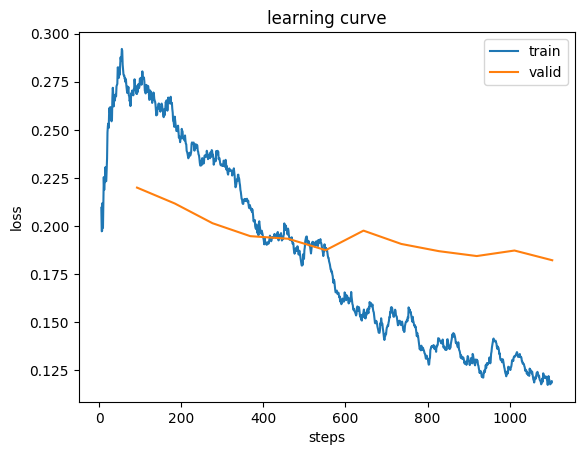

In [6]:
learn.recorder.plot_loss()